# Creating charts for the New AutoMotive Index

We want three main charts:
- Miles travelled by ICEs (or all cars)
- Miles travelled by BEVs
- Selective chart with miles travelled by Make / Model

And we want the make up of all cars on the road by count of BEV / non-BEV



In [12]:
# setup libaries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas_ods_reader import read_ods
import re

## 1. ICE mileage over time

Start with total cars on the road.

In [13]:
# Parse DfT data on licensed vehicles
filepath = '../data/DfT/veh0120.ods'
df = read_ods(filepath, 'Cars')
headers = df.iloc[5]
df = df.iloc[6:48445]
df.columns = headers

In [14]:
# How many cars on the road?
print(f"Cars on the road: {df['2020 Q3 UK'].sum() / 1_000_000}m")
print(f"Total Teslas: {df[df['Make'] == 'TESLA']['2020 Q3 UK'].sum()}")
print(f"Teslas sold in 2020: {df[df['Make'] == 'TESLA']['2020 Q3 UK'].sum() - df[df['Make'] == 'TESLA']['2019 Q4 UK'].sum()}")

Cars on the road: 32.869865m
Total Teslas: 41314.0
Teslas sold in 2020: 16423.0


In [15]:
df_GB = df[['Make', 'Model 1', '2020 Q3 GB', '2020 Q2 GB', '2020 Q1 GB',
       '2019 Q4 GB', '2019 Q3 GB', '2019 Q2 GB', '2019 Q1 GB', '2018 Q4 GB',
       '2018 Q3 GB', '2018 Q2 GB', '2018 Q1 GB', '2017 Q4 GB', '2017 Q3 GB',
       '2017 Q2 GB', '2017 Q1 GB', '2016 Q4 GB', '2016 Q3 GB', '2016 Q2 GB',
       '2016 Q1 GB', '2015 Q4 GB', '2015 Q3 GB', '2015 Q2 GB', '2015 Q1 GB',
       '2014 Q4 GB', '2014 Q3 GB', '2014 Q2', '2014 Q1', '2013 Q4', '2013 Q3',
       '2013 Q2', '2013 Q1', '2012 Q4', '2012 Q3', '2012 Q2', '2012 Q1',
       '2011 Q4', '2011 Q3', '2011 Q2', '2011 Q1', '2010 Q4', '2010 Q3',
       '2010 Q2', '2010 Q1', '2009 Q4', '2009 Q3', '2009 Q2', '2009 Q1',
       '2008 Q4', '2008 Q3']]

df_UK = df[['Make', 'Model 1', '2020 Q3 UK', '2020 Q2 UK', '2020 Q1 UK',
       '2019 Q4 UK', '2019 Q3 UK', '2019 Q2 UK', '2019 Q1 UK', '2018 Q4 UK',
       '2018 Q3 UK', '2018 Q2 UK', '2018 Q1 UK', '2017 Q4 UK', '2017 Q3 UK',
       '2017 Q2 UK', '2017 Q1 UK', '2016 Q4 UK', '2016 Q3 UK', '2016 Q2 UK',
       '2016 Q1 UK', '2015 Q4 UK', '2015 Q3 UK', '2015 Q2 UK', '2015 Q1 UK',
       '2014 Q4 UK', '2014 Q3 UK']]

Instead of these column names, we'll replace them with a date series range that we'll create, quarterly.

In [16]:
total_cars = df_GB.sum()[2:]
total_cars = pd.DataFrame(total_cars).reset_index()
total_cars.columns = ['date', 'cars']
total_cars.drop(['date'], axis=1, inplace=True)
total_cars['date'] = pd.date_range(start='2008-09-30', end='2020-09-30', freq='Q')[::-1]
total_cars = total_cars.set_index('date')

<AxesSubplot:xlabel='date'>

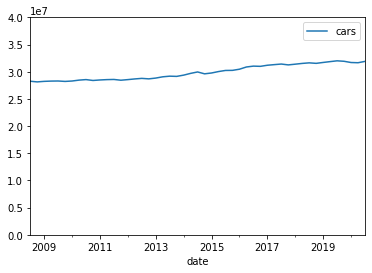

In [17]:
# total cars on the road, quarterly
total_cars.plot(ylim=(0, 4e7))

Now take the average mileage per year

In [18]:
# ICE miles travelled over time

# Research shows avg miles travelled should be falling e.g. 
# https://www.bymiles.co.uk/insure/magazine/mot-data-research-and-analysis/
# from there we get avg miles per car:
avg = pd.DataFrame([], columns=['date', 'mileage'])
avg['date'] = [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007]
avg['date'] = pd.to_datetime(avg['date'], format='%Y')
avg['mileage'] = [7090, 7059, 7134, 7250, 7334, 7421, 7409, 7467, 7473, 7559, 7524, 7637, 7712]

In [19]:
# resample to get quarterly figures
avg = avg.set_index('date').resample('Q').pad()

In [20]:
# extending forwards flat with covid adjustment
# Assumptions (these are the median values for car travel taken from the 'COVID-19-transport-use-statistics.csv' dataset): 
Q1 = 0.93
Q2 = 0.50
Q3 = 0.89
avg.loc['2019-03-31'] = 7090
avg.loc['2019-06-30'] = 7090
avg.loc['2019-09-30'] = 7090
avg.loc['2019-12-31'] = 7090
avg.loc['2020-03-31'] = 7090 * Q1
avg.loc['2020-06-30'] = 7090 * Q2 
avg.loc['2020-09-30'] = 7090 * Q3

<AxesSubplot:xlabel='date'>

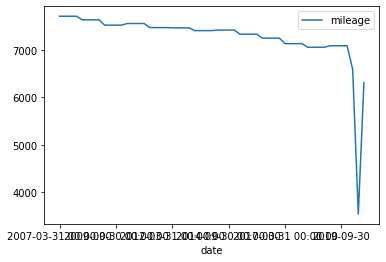

In [21]:
avg.plot()

Now merge these together to create total miles travelled over time

In [22]:
# merge these
total_m = pd.merge(avg.reset_index(), total_cars.reset_index())

In [23]:
# total miles per year
total_m['miles_quarterly'] = 0.25 * total_m['mileage'] * total_m['cars']

<AxesSubplot:title={'center':'Car miles travelled over time'}, xlabel='date'>

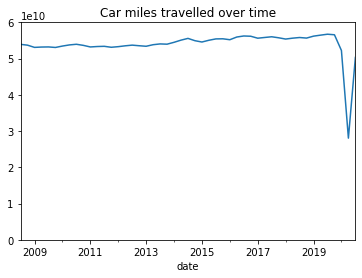

In [24]:
total_m.set_index('date')['miles_quarterly'].plot(title='Car miles travelled over time', ylim=[0, 6e10])

Now export that to chartJS

In [25]:
# total_m.set_index('date')['miles_quarterly'].cumsum().plot(title='Cumulative Car miles travelled over time')

# export this to a useful format to plot in chartjs
# total_m[['date', 'miles_quarterly']]

## 2. BEV miles travelled

First some fundamentals. There have been something like "164,000 BEVs on the roads by end of Q3 2020". 
It's taken around 10 years to get there. So assuming a straight line and slightly lower (?) average miles, say 5000,  
We're looking at something like 800m to 1bn+ miles travelled, cumulative.  
With the majority of that in the last year or two.

Take BEV sales over time

In [26]:
# BEV sales
electric = pd.read_csv('../data/ev_dataset.csv')
electric.columns = ['count', 'make', 'model', 'type']

In [27]:
bevs = electric[electric['type'] == 'BEV']

In [28]:
bevs['count'].sum()

33492

In [29]:
# bevs[bevs['Company']=='NISSAN']

From SMMT data we know that there were 108,205 BEV registrations in 2020!  
Up from 37,850 in 2019.  
We want to identify the makes / models to tally that up with the DfT licensed stats.

https://www.smmt.co.uk/2021/01/uk-automotive-looks-to-green-recovery-strategy-after-29-4-fall-in-new-car-registrations-in-2020/


We need to combine model types. 

In [30]:
#Dictionary of Matched Make:model
cars = {'RENAULT':'ZOE', 'NISSAN':'LEAF', 'NISSAN': 'E-NV200', 'TESLA':'MODEL S', 'BMW': 'I3', 'PEUGEOT':'ION', 'JAGUAR':'I-PACE', 'CHEVROLET': 'VOLT', 'AUDI':'E-TRON', 'MG':'ZS'}

In [31]:
def combine_models(make,model,row):
    """Tries to combine multiple vehicle versions for a specified make or model.
    \\b specifies word boundaries in regex, including start and end of lines.

    E.g. NISSAN, LEAF Model x: (NISSAN, LEAF, row) -> NISSAN, LEAF
    """
    return model if (row['make'] == make) & (bool(re.match(f'\\b{model}\\b', row['model']))) else row['model']

In [32]:
for key, value in cars.items(): 
    bevs['model'] = bevs.apply(lambda x: combine_models(key,value, x), axis = 1)

<ipython-input-32-e3bc3914563e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bevs['model'] = bevs.apply(lambda x: combine_models(key,value, x), axis = 1)


In [33]:
bevs = bevs.groupby(['make', 'model']).sum().reset_index().sort_values('count', ascending=False)

In [34]:
bevs

,make,model,count
42,NISSAN,LEAF,18701
61,RENAULT,ZOE,5437
8,BMW,I3,2167
76,TESLA,MODEL S,1283
52,RENAULT,KANGOO,848
...,...,...,...
29,KIA,NIRO,4
66,SAITING,SCOOTER,3
87,VOLKSWAGEN,E-GOLF,3
74,TESLA,MODEL 3,2


### SMMT top level BEV sales

In [35]:
bev_sales = pd.DataFrame()
bev_sales['sales'] = [0, 0, 1, 2, 7, 10, 11, 14, 16, 38, 108] # in thousands
bev_sales['year'] = pd.date_range('2010-01-01', '2021-01-01', freq='Y')

In [36]:
bev_sales['cum_sales'] = bev_sales['sales'].cumsum()

In [37]:
# avg miles travelled for EVs 
avg_ev_mileage = 6000
bev_sales['mileage'] = bev_sales['sales'] * 1000 * avg_ev_mileage

In [38]:
# covid factor 
factor = (0.93 + 0.5 + 0.89 + 0.6) / 4

bev_sales['mileage'] = bev_sales['mileage'] * [*np.ones(10), factor]


In [39]:
bev_sales['cum_mileage'] = bev_sales['mileage'].cumsum() / 1e9

In [40]:
bev_sales

,sales,year,cum_sales,mileage,cum_mileage
0,0,2010-12-31,0,0.0,0.00000
1,0,2011-12-31,0,0.0,0.00000
2,1,2012-12-31,1,6000000.0,0.00600
3,2,2013-12-31,3,12000000.0,0.01800
4,7,2014-12-31,10,42000000.0,0.06000
5,10,2015-12-31,20,60000000.0,0.12000
6,11,2016-12-31,31,66000000.0,0.18600
7,14,2017-12-31,45,84000000.0,0.27000
8,16,2018-12-31,61,96000000.0,0.36600
9,38,2019-12-31,99,228000000.0,0.59400


In [41]:
years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
miles_travelled = [0.0000,0.0000,0.0050,0.0150,0.0500,0.1000,0.1550,0.2250,0.3050,0.4950,0.8892]

In [42]:
list(zip(years, miles_travelled))

[(2010, 0.0),
 (2011, 0.0),
 (2012, 0.005),
 (2013, 0.015),
 (2014, 0.05),
 (2015, 0.1),
 (2016, 0.155),
 (2017, 0.225),
 (2018, 0.305),
 (2019, 0.495),
 (2020, 0.8892)]

# 3. Miles Travelled by Make and Model

We want to create a multi-select line chart for any make and model of vehicle showing its miles travelled over time.

In [43]:
df_GB.sort_values('2020 Q3 GB', ascending=False).head(100).T.to_json('testjson.json.gz')

We want our frontend application to consume the data as a JSON file.  
Uncompressed, 20,000 rows is around 10MB which is a little too much.  
Specifying the filename with .gz will compress the JSON automatically.  
This gets us to 2.8MB, much better.

In [44]:
df_GB.sort_values('2020 Q3 GB', ascending=False).head(20000).T.to_json('testjson.json.gz')

In [45]:
df_GB.sort_values('2020 Q3 GB', ascending=False).head(20000)['2020 Q3 GB'].sum() / df_GB['2020 Q3 GB'].sum()

0.9819494152524159

And 20,000 vehicle types is showing us 98% of all vehicles.  
Note this isn't totally cleaned up ie there are lots of small variants of vehicles.

Let's try and optimise the file size

In [46]:
# Try reducing chars in column names
df_GB.columns = ['mk', 'md', 'q3_20', 'q2_20', 'q1_20', 'q4_19', 'q3_19', 'q2_19', 'q1_19', 'q4_18', 'q3_18', 'q2_18', 'q1_18', 'q4_17', 'q3_17', 'q2_17', 'q1_17', 'q4_16', 'q3_16', 'q2_16', 'q1_16', 'q4_15', 'q3_15', 'q2_15', 'q1_15', 'q4_14', 'q3_14', 'q2_14', 'q1_14', 'q4_13', 'q3_13', 'q2_13', 'q1_13', 'q4_12', 'q3_12', 'q2_12', 'q1_12', 'q4_11', 'q3_11', 'q2_11', 'q1_11', 'q4_10', 'q3_10', 'q2_10', 'q1_10', 'q4_09', 'q3_09', 'q2_09', 'q1_09', 'q4_08', 'q3_08']

# df_GB.sort_values('20Q3', ascending=False).head(20000).T.to_json('testjson.json.gz')

Reducing column names took us to 2.6MB compressed so barely worth it - gzip compression does most of the work!

In [47]:
df_GB.sort_values('q3_20', ascending=False).T.to_json('vehicle_counts.json.gz')

All vehicles is 4.7MB with smaller names. So lets go with that.

Ok, we have vehicle counts over time. Now we need avg miles travelled per vehicle to get miles travelled per quarter.  
Need to ask BigQuery for this.

In [48]:
project_id = "rugged-baton-283921"
import mileage_transform as mt
import pandas_gbq

GCP_credentials_fp = "../dependencies/NAM-index-credentials.json"
Querier = mt.BigQuerier(GCP_credentials_fp)

ModuleNotFoundError: No module named 'google'

Write df_GB to BigQuery so we can join on the make and model list.  
But first we need to add in year values to match with average yearly mileage  
To do this we need to put df_GB into long format, rather than wide

In [ ]:
df_GB_long = pd.melt(df_GB, id_vars=['mk', 'md'])

In [ ]:
df_GB_long['year'] = '20' + df_GB_long['variable'].str[-2:]
df_GB_long['year'] = pd.to_numeric(df_GB_long['year'])

In [ ]:
# pandas_gbq.to_gbq(df_GB_long, 'mots.vehicle_counts_GB_long', project_id=project_id) # if_exists='replace'

### *TODO this matching misses lots of things, so both datasets need transforming to 'cleaned' model names first

In [ ]:
sql_query = (
    """
    SELECT avg_annual_mileage, vehicle_count, make, model, fuelType, year
    FROM mots.avg_miles_make_model_fueltype_2019
    JOIN mots.vehicle_counts_GB_long
    ON avg_miles_make_model_fueltype_2019.make = vehicle_counts_GB.mk
    AND avg_miles_make_model_fueltype_2019.model = vehicle_counts_GB.md
    WHERE year > 2009
    """
    )

df = Querier.smart_query('avg_miles_per_vehicle', sql_query)

I need a timeseries of avg miles travelled per make and model, so need to do that in BigQUery.  
The following query should do it:   
"""
SELECT 12 * SUM(mileage.mileage)/COUNT(*) as avg_annual_mileage, COUNT(*)/12 as vehicle_count, vehicles.make, vehicles.model, vehicles.fuelType, EXTRACT(YEAR from mileage.date) as year,
FROM mots.mileage
JOIN mots.vehicles on mileage.registration = vehicles.registration
where mileage.mileage < 2000
GROUP BY vehicles.make, vehicles.model, vehicles.fuelType, year
"""  

Saved as new table, `avg_miles_make_model_timeseries`.  
Needs cleaning as older years have 0 results.  

Now we have everything long, we can turn the quarterly counts and yearly average miles per make and model into a dataframe

In [ ]:
sql_query = (
    """
    select count, make, model, fuelType, year, quarter, avg_annual_mileage, avg_annual_mileage * CAST(count as FLOAT64) as quarterly_mileage
    FROM mots.miles_travelled_yearly_make_model
    """
    )
df = Querier.smart_query('quarterly_miles_make_model', sql_query)

In [ ]:
df.head(1)

Don't forget to reintroduce the COVID factors from before!

In [ ]:
Q1, Q2, Q3

In [ ]:
df.loc[df.quarter == 'q1_20', 'quarterly_mileage'] =  df[df['quarter'] == 'q1_20']['quarterly_mileage'] * Q1
df.loc[df.quarter == 'q2_20', 'quarterly_mileage'] =  df[df['quarter'] == 'q2_20']['quarterly_mileage'] * Q2
df.loc[df.quarter == 'q3_20', 'quarterly_mileage'] =  df[df['quarter'] == 'q3_20']['quarterly_mileage'] * Q3

In [ ]:
df.head(1)

Check how many matched vehicles we have - sums to 20m, which isn't fantastic

In [ ]:
pd.to_numeric(df[df['quarter'] == 'q3_20']['count']).sum()

In [ ]:
df = df.drop_duplicates(['make', 'model', 'fuelType', 'quarter'])

In [ ]:
df.sort_values('quarterly_mileage', ascending=False).head()

### Pivot

We want this to be consumed in a frontend app in JSON form. 

Get the table wide, so ready for JSON export

In [ ]:
pivot = df.pivot_table(values='quarterly_mileage', index=['make', 'model', 'fuelType'], columns='quarter')

In [ ]:
pivot = pivot[['q1_10', 'q2_10', 'q3_10', 'q4_10', 'q1_11', 'q2_11', 'q3_11', 'q4_11', 'q1_12', 'q2_12', 'q3_12', 'q4_12', 'q1_13', 'q2_13', 'q3_13', 'q4_13', 'q1_14', 'q2_14', 'q3_14', 'q4_14', 'q1_15', 'q2_15', 'q3_15', 'q4_15', 'q1_16', 'q2_16', 'q3_16', 'q4_16', 'q1_17', 'q2_17', 'q3_17', 'q4_17', 'q1_18', 'q2_18', 'q3_18', 'q4_18', 'q1_19', 'q2_19', 'q3_19', 'q4_19', 'q1_20', 'q2_20', 'q3_20']]

Prepare to export to JSON

BigQuery complained about number first column headers, but now javascipt is ordering them wrong, so we need to go back to numbers first.

In [ ]:
pivot.columns = ['10_q1','10_q2','10_q3','10_q4','11_q1','11_q2','11_q3','11_q4','12_q1','12_q2','12_q3','12_q4','13_q1','13_q2','13_q3','13_q4','14_q1','14_q2','14_q3','14_q4','15_q1','15_q2','15_q3','15_q4','16_q1','16_q2','16_q3','16_q4','17_q1','17_q2','17_q3','17_q4','18_q1','18_q2','18_q3','18_q4','19_q1','19_q2','19_q3','19_q4','20_q1','20_q2','20_q3']

In [ ]:
# pivot

In [ ]:
# Ideally data is like this
# {
# make: AIXAM,
# model: 500 LUXE,
# fuel: diesel,
# miles: [1, 2, 26,...]
# }

In [ ]:
# pivot

## Sense check

In [ ]:
# This doesn't look quite right
pivot.groupby('fuelType').sum().T.plot()

In [ ]:
pivot.groupby('fuelType').sum().sum().plot(title='Total miles travelled')

Obviously this is a problem, as total miles travelled should be closer to 3bn continuously! 

In [ ]:
pivot.groupby('fuelType').sum().T['Electric'].plot()

The overallocation of electric is also a problem.

In [ ]:
pivot.reset_index()[pivot.reset_index()['fuelType']=='Electric'].sort_values('10_q3', ascending=False).head(10)

Skewed heavily by Toyota PRIUS, Ford KA, HONDA CIVIC, FORD FIESTA, MAXDA MX-5, MG MGF, Vauxhall Cavalier, Peugeot 206, Volvo V70 etc etc.

## Clean up data 

### Remove small distracting fuel types

We have fuel types like steam and other oddities. They should all be removed before export. 

In [61]:
pivot = pivot.reset_index()

In [62]:
pivot.fuelType.value_counts()

Petrol                     11390
Diesel                      8218
LPG                          826
Electric                     220
Hybrid Electric (Clean)      147
Other                        128
Gas Bi-Fuel                  106
Gas                           27
CNG                           24
Steam                         20
LNG                           18
Fuel Cells                    11
Electric Diesel               11
Gas Diesel                     9
Name: fuelType, dtype: int64

In [63]:
pivot.groupby('fuelType').sum()['20_q3'].sort_values(ascending=False)

fuelType
Petrol                     6.965668e+10
Diesel                     6.444181e+10
LPG                        5.330772e+09
Hybrid Electric (Clean)    2.123061e+09
Electric                   1.985562e+09
Gas Bi-Fuel                1.666237e+09
Other                      9.613532e+08
CNG                        5.615988e+08
Steam                      3.076621e+08
Gas Diesel                 1.640697e+08
Gas                        7.311145e+07
Fuel Cells                 6.793553e+07
LNG                        5.268771e+07
Electric Diesel            2.603524e+07
Name: 20_q3, dtype: float64

This shows steam vehicles travelling 300 million miles in 2020 Q3 ??!

In [64]:
pivot.groupby(['make', 'model']).sum()['20_q3'].sort_values(ascending=False).head(60)

make        model                    
FORD        FIESTA ZETEC                 6.689075e+09
MINI        COOPER                       1.823438e+09
VAUXHALL    ASTRA SRI                    1.467230e+09
FORD        FOCUS ZETEC                  1.228512e+09
VAUXHALL    CORSA SXI                    1.168426e+09
FORD        FOCUS ZETEC 100              1.075959e+09
VOLKSWAGEN  GOLF                         1.063689e+09
VAUXHALL    CORSA SXI AC                 1.058330e+09
MINI        MINI COOPER                  1.047199e+09
FORD        FOCUS TITANIUM               9.531826e+08
PEUGEOT     208 ACTIVE                   8.593846e+08
MINI        ONE                          8.579144e+08
FORD        FOCUS ZETEC TDCI             7.884432e+08
            FIESTA TITANIUM              7.459034e+08
            FOCUS LX                     7.172051e+08
VOLKSWAGEN  GOLF GT TDI                  6.582883e+08
VAUXHALL    CORSA SE                     6.167398e+08
MINI        COOPER D                     6.0

In [65]:
# Inspect steam types
# pivot[pivot.fuelType=='Steam']

It's clear from inspection the Steam fueltypes are all wrong / lies. So let's discard.

In [66]:
keep_fuel_types = ["Petrol", "Diesel", "LPG", "Electric", "Hybrid Electric (Clean)", "Other"]
pivot = pivot[pivot.fuelType.isin(keep_fuel_types)]

In [104]:
# Change "Hybrid Electric (Clean)" to "Hybrid"
pivot.loc[pivot.fuelType=="Hybrid Electric (Clean)", 'fuelType'] = 'Hybrid'

### Classify fuel types from models

In [105]:
# only really mitsubishi outlander
# pivot[pivot.model.str.contains('PHEV')]

### Aggregate similar makes of vehicles

In [106]:
# drop all unknown models
pivot = pivot[pivot.model!='UNKNOWN']

In [107]:
# strip out some annoying keywords

# pivot[pivot.model.str.contains('ZETEC')].model.unique()
pivot.model = pivot.model.str.replace(' ZETEC', '')

In [108]:
# pivot[pivot.model.str.contains('LEAF')].make.unique() # only Nissan makes LEAF
pivot.loc[pivot.model.str.contains('LEAF'), 'model'] = 'LEAF'

In [109]:
pivot.loc[pivot.model.str.contains('FIESTA'), 'model'] = 'FIESTA'

In [110]:
pivot.loc[pivot.model.str.contains('TRANSIT'), 'model'] = 'TRANSIT'

In [111]:
pivot.loc[pivot.model.str.contains('MONDEO'), 'model'] = 'MONDEO'

In [112]:
pivot.make.value_counts()

VAUXHALL    2566
RENAULT     2144
PEUGEOT     1827
VOLVO       1764
FORD        1324
            ... 
ADLY           1
DODGE          1
MZ             1
SANYANG        1
GSMOON         1
Name: make, Length: 160, dtype: int64

In [113]:
pivot[pivot.make=='VAUXHALL'].model.value_counts()

ASTRA                     688
CORSA                     433
VECTRA                    328
INSIGNIA                  218
AGILA                      30
                         ... 
BRAVA DI 4X2                1
CAVALIER ENVOY D            1
TIGRA EXCLUSIV 16V          1
OMEGA V6 SPECIAL AUTO       1
OMEGA 2.0 16V SELECT A      1
Name: model, Length: 650, dtype: int64

In [114]:
len(pivot.model.unique())

12782

In [122]:
# Restrict to a make due to name conflicts
aggregate_names = [
    ['BMW', '520D'],
    ['FIAT', '500'],
    ['FIAT', 'PANDA'],
    ['FIAT', 'BRAVO'],
    ['FIAT', 'DOBLO'],
    ['FIAT', 'STILO'],
    ['FORD', 'C-MAX'],
    ['FORD', 'KA'],
    ['FORD', 'S-MAX'],
    ['FORD', 'CORTINA'],
    ['FORD', 'GALAXY'],
    ['FORD', 'TORNEO'],
    ['FORD', 'EXPLORER'],
    ['FORD', 'ESCORT'],
    ['FORD', 'SIERRA'],
    ['FORD', 'MAVERICK'],
    ['FORD', 'FIESTA'],
    ['FORD', 'FOCUS'],
    ['FORD', 'FUSION'],
    ['FORD', 'CLASSIC'],
    ['FORD', 'CAPRII'],
    ['FORD', 'COUGAR'],
    ['FORD', 'SCORPIO'],
    ['FORD', 'MONDEO'],
    ['MINI', 'COOPER'],
    ['MINI', 'ONE'],
    ['NISSAN', 'MICRA'],
    ['NISSAN', 'NOTE'],
    ['NISSAN', 'QASHQAI'],
    ['NISSAN', 'ALMERA'],
    ['NISSAN', 'JUKE'],
    ['NISSAN', 'PRIMERA'],
    ['PEUGEOT', '108'],
    ['PEUGEOT', '208'],
    ['VAUXHALL', 'ASTRA'],
    ['VAUXHALL', 'CORSA'],
    ['VAUXHALL', 'VECTRA'],
    ['VAUXHALL', 'INSIGNIA'],
    ['VAUXHALL', 'ANTARA'],
    ['VAUXHALL', 'MOKKA'],
    ['VAUXHALL', 'AGILA'],
    ['VOLKSWAGEN', 'GOLF'],
    ['VOLKSWAGEN', 'PASSAT'],
    ['VOLKSWAGEN', 'POLO'],
    ["BMW", "118D,"],
    ["BMW", "X5"],
    ["FIAT", "PUNTO"],
    ["FORD", "KA "],
    ["FORD", "KUGA"],
    ["HONDA", "JAZZ"],
    ["KIA", "PICANTO"],
    ["MAZDA", "MX-5"],
    ["MITSUBISHI", "OUTLANDER"],
    ["PEUGEOT", "106"],
    ["PEUGEOT", "107"],
    ["PEUGEOT", "206"],
    ["PEUGEOT", "207"],
    ["PEUGEOT", "208"],
    ["PEUGEOT", "307"],
    ["PEUGEOT", "308"],
    ["PEUGEOT", "3008"],
    ["PEUGEOT", "406"],
    ["PEUGEOT", "407"],
    ["PEUGEOT", "408"],
    ["RENAULT", "CLIO"],
    ["RENAULT", "MEGANE"],
    ["TOYOTA", "PRIUS"],
    ["TOYOTA", "YARIS"],
]

In [131]:
print("Searching for model variants and changing them to base model name")
print("-------------------")
for make, model in aggregate_names:
    exact_model_count = pivot.loc[(pivot.make==make) & (pivot.model==model), 'make'].count()
    variant_model_count = pivot.loc[(pivot.make==make) & (pivot.model.str.contains(model)), 'make'].count()
    print(
        f"{make} {model} "
        f" - changing {variant_model_count - exact_model_count} for a total of {variant_model_count + exact_model_count}"
    )
    pivot.loc[(pivot.make==make) & (pivot.model.str.contains(model)), 'model'] = model

Searching for model variants and changing them to base model name
-------------------
BMW 520D  - changing 0 for a total of 6
FIAT 500  - changing 0 for a total of 48
FIAT PANDA  - changing 0 for a total of 56
FIAT BRAVO  - changing 0 for a total of 54
FIAT DOBLO  - changing 0 for a total of 38
FIAT STILO  - changing 0 for a total of 34
FORD C-MAX  - changing 0 for a total of 16
FORD KA  - changing 0 for a total of 54
FORD S-MAX  - changing 0 for a total of 34
FORD CORTINA  - changing 0 for a total of 10
FORD GALAXY  - changing 0 for a total of 142
FORD TORNEO  - changing 0 for a total of 0
FORD EXPLORER  - changing 0 for a total of 4
FORD ESCORT  - changing 0 for a total of 388
FORD SIERRA  - changing 0 for a total of 156
FORD MAVERICK  - changing 0 for a total of 46
FORD FIESTA  - changing 0 for a total of 438
FORD FOCUS  - changing 0 for a total of 208
FORD FUSION  - changing 0 for a total of 34
FORD CLASSIC  - changing 0 for a total of 4
FORD CAPRII  - changing 0 for a total of 0
F

In [124]:
len(pivot.model.unique())

12090

## Export

In [125]:
# pivot.reset_index().head().to_json(orient='records')

In [126]:
# pivot.sort_values('20_q3', ascending=False).head(10000)

In [127]:
pivot.sort_values('20_q3', ascending=False).head(10000).to_json('miles_travelled_vehicles.json', orient='split', index=False)

In [128]:
# pivot.reset_index()[pivot.reset_index()['make']=='TESLA'].to_json(orient='records')